In [51]:
from pybroker import Strategy, YFinance, highest

def exec_fn(ctx):
   # Get the rolling 10 day high.
   high_10d = ctx.indicator('high_10d')
   # Buy on a new 10 day high.
   if not ctx.long_pos() and high_10d[-1] > high_10d[-2]:
      ctx.buy_shares = 100
      # Hold the position for 5 days.
      ctx.hold_bars = 5
      # Set a stop loss of 2%.
      ctx.stop_loss_pct = 2

strategy = Strategy(YFinance(), start_date='1/1/2022', end_date='7/1/2022')
strategy.add_execution(
   exec_fn, ['AAPL', 'MSFT'], indicators=highest('high_10d', 'close', period=10))
# Run the backtest after 20 days have passed.
result = strategy.backtest(warmup=20)

Backtesting: 2022-01-01 00:00:00 to 2022-07-01 00:00:00

Loading bar data...


[*********************100%***********************]  2 of 2 completed


Loaded bar data: 0:00:07 

Computing indicators...


  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 50% (1 of 2) |#############             | Elapsed Time: 0:00:10 ETA:   0:00:10
100% (2 of 2) |##########################| Elapsed Time: 0:00:10 Time:  0:00:10



Test split: 2022-01-03 00:00:00 to 2022-06-30 00:00:00


  0% (0 of 124) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (124 of 124) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:18


Backtesting: 2020-01-01 00:00:00 to 2025-01-01 00:00:00

Loaded cached bar data.

Test split: 2020-01-02 00:00:00 to 2024-12-31 00:00:00


  0% (0 of 1212) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
 25% (311 of 1212) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00
 62% (761 of 1212) |#############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 98% (1191 of 1212) |################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (1212 of 1212) |####################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:00


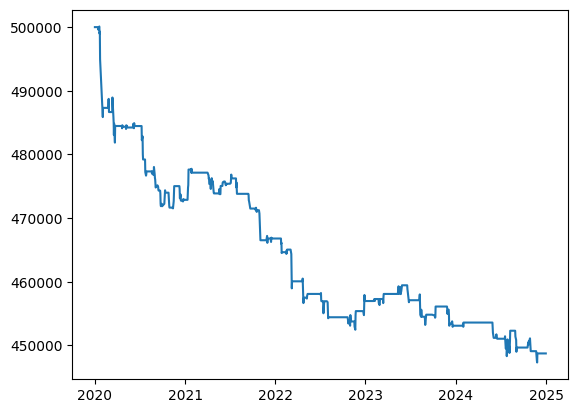

In [14]:
from pybroker.ext.data import AKShare
import pybroker
from pybroker import Strategy, StrategyConfig
import matplotlib.pyplot as plt

pybroker.enable_data_source_cache('my_strategy')
config = StrategyConfig(initial_cash=500_000)
strategy = Strategy(AKShare(), '20200101', '20250101', config)


def buy_low(ctx):
    # If shares were already purchased and are currently being held, then return.
    if ctx.long_pos():
        return
    # If the latest close price is less than the previous day's low price,
    # then place a buy order.
    if ctx.bars >= 2 and ctx.close[-1] < ctx.low[-2]:
        # Buy a number of shares that is equal to 25% the portfolio.
        ctx.buy_shares = ctx.calc_target_shares(0.25)
        # Set the limit price of the order.
        ctx.buy_limit_price = ctx.close[-1] - 0.01
        # Hold the position for 3 bars before liquidating (in this case, 3 days).
        ctx.hold_bars = 3

strategy.add_execution(buy_low, ['600000.SH'])

result = strategy.backtest()


chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

Backtesting: 2019-01-01 00:00:00 to 2025-01-01 00:00:00

Loaded cached bar data.

Test split: 2019-01-02 00:00:00 to 2024-12-31 00:00:00


  0% (0 of 1510) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (21 of 1510) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05
  2% (41 of 1510) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04
  4% (61 of 1510) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04
  5% (81 of 1510) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:04
  8% (121 of 1510) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:03
  9% (141 of 1510) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 11% (181 of 1510) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 13% (211 of 1510) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 16% (251 of 1510) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:03
 17% (271 of 1510) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:03
 20% (311 of 1510) |####                 | Elapsed Time: 0:00:00 ETA:   0:00:03
 23% (351 of 1510) |####                


Finished backtest: 0:00:04


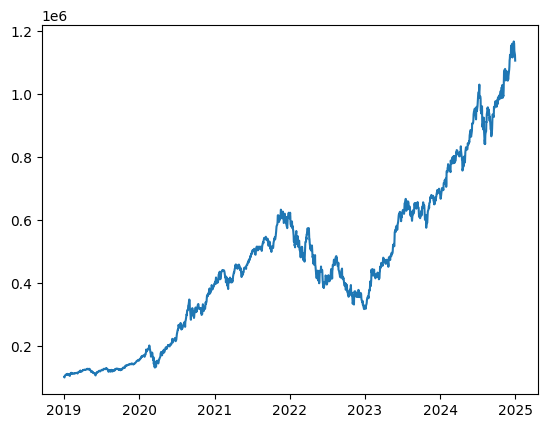

In [49]:
import pybroker as pyb
from datetime import datetime
from pybroker import ExecContext, Strategy, YFinance
import matplotlib.pyplot as plt

pyb.enable_data_source_cache('rebalancing')

def start_of_month(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    if dt.month != pyb.param('current_month'):
        pyb.param('current_month', dt.month)
        return True
    return False

def start_of_year(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    if dt.year != pyb.param('current_year'):
        pyb.param('current_year', dt.year)
        return True
    return False

def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares

def rebalance(ctxs: dict[str, ExecContext]):
    if start_of_year(ctxs):
        target = 1 / len(ctxs)
        set_target_shares(ctxs, {symbol: target for symbol in ctxs.keys()})

strategy = Strategy(YFinance(), start_date='1/1/2019', end_date='1/1/2025')

strategy.add_execution(None, ['TSLA', 'AAPL', 'NVDA', 'AMZN','GOOG','MSFT','META'])


# strategy.add_execution(None, ['MOAT', 'PFF', 'VNQ', 'RSP'])
# strategy.add_execution(None, ['TSLA', 'NFLX', 'AAPL', 'NVDA', 'AMZN'])

# strategy.add_execution(None, ['MOAT', 'PFF', 'VNQ', 'RSP', 'TSLA', 'NFLX', 'AAPL', 'NVDA', 'AMZN'])

strategy.set_after_exec(rebalance)
result = strategy.backtest()    

result.orders.to_csv("./data/broker_orders.csv")
result.metrics_df.to_csv("./data/broker_metrices_df.csv")
result.portfolio.to_csv("./data/broker_portfolio.csv")


chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])


In [55]:
# China

import pybroker as pyb
from datetime import datetime
from pybroker import ExecContext, Strategy, YFinance
import matplotlib.pyplot as plt
from pybroker.ext.data import AKShare


pyb.enable_data_source_cache('rebalancing')

def start_of_month(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    if dt.month != pyb.param('current_month'):
        pyb.param('current_month', dt.month)
        return True
    return False

def start_of_year(ctxs: dict[str, ExecContext]) -> bool:
    dt = tuple(ctxs.values())[0].dt
    if dt.year != pyb.param('current_year'):
        pyb.param('current_year', dt.year)
        return True
    return False

def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares

def rebalance(ctxs: dict[str, ExecContext]):
    if start_of_year(ctxs):
        target = 1 / len(ctxs)
        set_target_shares(ctxs, {symbol: target for symbol in ctxs.keys()})

strategy = Strategy(AKShare(), start_date='1/1/2023', end_date='1/1/2025')

strategy.add_execution(None, ['520580.SZ'])


# strategy.add_execution(None, ['MOAT', 'PFF', 'VNQ', 'RSP'])
# strategy.add_execution(None, ['TSLA', 'NFLX', 'AAPL', 'NVDA', 'AMZN'])

# strategy.add_execution(None, ['MOAT', 'PFF', 'VNQ', 'RSP', 'TSLA', 'NFLX', 'AAPL', 'NVDA', 'AMZN'])

strategy.set_after_exec(rebalance)
result = strategy.backtest()    

print(result.metrics_df)
print(result.portfolio)


chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])


Backtesting: 2023-01-01 00:00:00 to 2025-01-01 00:00:00

Loading bar data...
Loaded bar data: 0:00:00 



ValueError: DataSource is empty.